# Autoencoders for Anomaly Detection

Based on the article at https://bit.ly/2VgNyl7, made for the bonus task of the cyber data analytics class. Download the data and adjust the paths in the next cells.

Requires 
* seaborn
* tensorflow
* keras
* sklearn
* pyplot, pylab

and for visualizing the network also the graphviz package. Install directly from the notebook with **!pip install package**

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

SEED = 123 
DATA_SPLIT_PCT = 0.2

LABELS = ["Normal","Attack"]

# please adjust the dataset paths
NORMAL = "../data/BATADAL_training1.csv"
MIXED = "../data/BATADAL_training2.csv"

# Add path to our code
import sys
sys.path.append("../")

In [35]:
from src.data import parse_to_df

df_normal = parse_to_df(NORMAL)
df_mixed = parse_to_df(MIXED)

display(df_normal.head())
display(df_mixed.head())

# df_normal =  pd.read_csv(NORMAL, skipinitialspace=True)
# df_mixed = pd.read_csv(MIXED, skipinitialspace=True)

,datetime,l_t1,l_t2,l_t3,l_t4,l_t5,l_t6,l_t7,f_pu1,s_pu1,...,p_j256,p_j289,p_j415,p_j302,p_j306,p_j307,p_j317,p_j14,p_j422,att_flag
h,,,,,,,,,,,,,,,,,,,,,
0,2014-01-06 00:00:00,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,2014-01-06 01:00:00,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,2014-01-06 02:00:00,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
3,2014-01-06 03:00:00,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
4,2014-01-06 04:00:00,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


,datetime,l_t1,l_t2,l_t3,l_t4,l_t5,l_t6,l_t7,f_pu1,s_pu1,...,p_j256,p_j289,p_j415,p_j302,p_j306,p_j307,p_j317,p_j14,p_j422,att_flag
h,,,,,,,,,,,,,,,,,,,,,
0,2016-07-04 00:00:00,2.44,5.24,3.19,4.10,2.86,5.50,4.39,93.63,1.0,...,70.00,28.22,85.87,21.69,82.72,21.58,71.99,39.33,29.64,-999
1,2016-07-04 01:00:00,2.66,4.53,3.20,4.18,3.29,5.44,4.53,89.41,1.0,...,87.73,24.45,84.87,29.81,86.62,29.81,59.76,42.17,26.15,-999
2,2016-07-04 02:00:00,3.11,3.66,3.66,4.21,3.87,5.15,3.22,89.88,1.0,...,89.29,23.90,87.11,29.85,87.64,29.85,58.50,42.00,25.56,-999
3,2016-07-04 03:00:00,3.62,3.04,4.17,4.04,3.56,4.98,2.40,88.10,1.0,...,91.98,27.10,68.75,31.60,64.25,31.47,72.30,43.24,28.38,-999
4,2016-07-04 04:00:00,4.08,2.68,4.73,3.20,3.11,5.39,3.46,87.01,1.0,...,92.11,26.76,68.74,32.30,64.23,32.17,72.53,44.00,28.04,-999


Harmonize the labels across the datasets to 0 / 1

Label the data correctly according to BATADAL

In [36]:
from src.data import label_data

# Correct labels are now in flag
df_mixed = label_data(df_mixed)

# Drop the att_flag col
# df_normal = df_normal.drop(['att_flag'], axis=1)
df_mixed = df_mixed.drop(['att_flag'], axis=1)

# Rename again to att_flag
# df_normal = df_normal.rename({'flag': 'att_flag'})
df_mixed = df_mixed.rename({'flag': 'att_flag'}, axis=1)

display(df['att_flag'].head())
display(df_mixed['att_flag'].head())

df_mixed.att_flag.replace([False, True], [0, 1], inplace=True)

display(df['att_flag'].head())
display(df_mixed['att_flag'].head())


0    0
1    0
2    0
3    0
4    0
Name: att_flag, dtype: int64

h
0    False
1    False
2    False
3    False
4    False
Name: att_flag, dtype: bool

0    0
1    0
2    0
3    0
4    0
Name: att_flag, dtype: int64

h
0    0
1    0
2    0
3    0
4    0
Name: att_flag, dtype: int64

Drop non-numeric columns, concatenate the dataframes.
We train the autoencoder on the normal data from BATADAL_dataset03 and test on BATADAL_dataset04

In [42]:
df_normal = df_normal.drop(['datetime'], axis=1)
df_mixed = df_mixed.drop(['datetime'], axis=1)

# display(df_normal.head())
# display(df_mixed.head())
df = pd.concat([df_normal, df_mixed], ignore_index=True)


Splitting into training, validation, testing, group into classes

In [43]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [44]:
df_train_0 = df_train.loc[df['att_flag'] == 0]
df_train_1 = df_train.loc[df['att_flag'] == 1]

df_train_0_x = df_train_0.drop(['att_flag'], axis=1)
df_train_1_x = df_train_1.drop(['att_flag'], axis=1)


df_valid_0 = df_valid.loc[df['att_flag'] == 0]
df_valid_1 = df_valid.loc[df['att_flag'] == 1]

df_valid_0_x = df_valid_0.drop(['att_flag'], axis=1)
df_valid_1_x = df_valid_1.drop(['att_flag'], axis=1)


df_test_0 = df_test.loc[df['att_flag'] == 0]
df_test_1 = df_test.loc[df['att_flag'] == 1]

df_test_0_x = df_test_0.drop(['att_flag'], axis=1)
df_test_1_x = df_test_1.drop(['att_flag'], axis=1)

Scale the data to 0-1 range

In [45]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['att_flag'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['att_flag'], axis = 1))

In [46]:
print(df_train_0_x_rescaled)

[[ 0.96581487  1.25715148 -1.39229519 ...  0.44729619 -0.30434929
   0.79627496]
 [-0.48522363 -1.58834884  0.73144963 ... -0.08565196 -1.19403832
  -0.62412399]
 [-0.42222618  1.03460772  1.38501288 ...  0.58157136 -0.40185226
   0.64061105]
 ...
 [ 0.56513004  0.49489182  0.9115085  ...  0.47095421 -0.53674551
   0.42525168]
 [-1.58307606 -0.69833496 -0.35532858 ...  0.69672805 -0.97477839
  -0.27407295]
 [ 0.87553969  1.13536638  1.62997767 ... -1.79880886  0.28256962
   1.73329859]]


## Set up a neural network with relu-encoder

In [47]:
nb_epoch = 100
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 16
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

This requires pydot and graphviz installed

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

## Train the network

In [48]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='rmsprop')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 7969 samples, validate on 1994 samples
Epoch 1/100
7969/7969 [==============================] - 0s 42us/step - loss: 1.8370 - acc: 0.0414 - val_loss: 1.5874 - val_acc: 0.0747
Epoch 2/100
7969/7969 [==============================] - 0s 15us/step - loss: 1.4511 - acc: 0.0688 - val_loss: 1.2342 - val_acc: 0.0707
Epoch 3/100
7969/7969 [==============================] - 0s 16us/step - loss: 1.1347 - acc: 0.0730 - val_loss: 0.9777 - val_acc: 0.0792
Epoch 4/100
7969/7969 [==============================] - 0s 18us/step - loss: 0.9448 - acc: 0.0617 - val_loss: 0.8575 - val_acc: 0.0572
Epoch 5/100
7969/7969 [==============================] - 0s 16us/step - loss: 0.8634 - acc: 0.0553 - val_loss: 0.8048 - val_acc: 0.0933
Epoch 6/100
7969/7969 [==============================] - 0s 13us/step - loss: 0.8201 - acc: 0.1331 - val_loss: 0.7714 - val_acc: 0.1625
Epoch 7/100
7969/7969 [==============================] - 0s 14us/step - loss: 0.7904 - acc: 0.1841 - val_loss: 0.7467 - val_acc: 0.1856


## Validate 

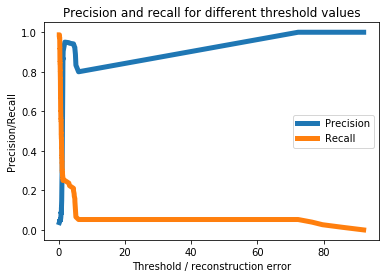

In [49]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['att_flag'] == 1})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold / reconstruction error')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Evaluate on testing

based on the above plot, choose a fixed threshold when the reconstruction error is too large

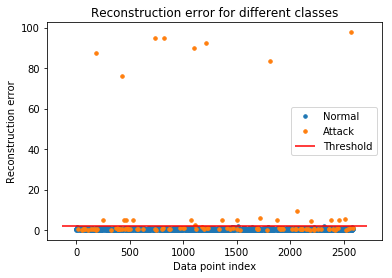

In [57]:
threshold_fixed = 2


test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['att_flag']})
error_df_test = error_df_test.reset_index()

groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### Use autoencoder to predict outliers

Predict *attack* label if reconstruction error larger than the chosen threshold

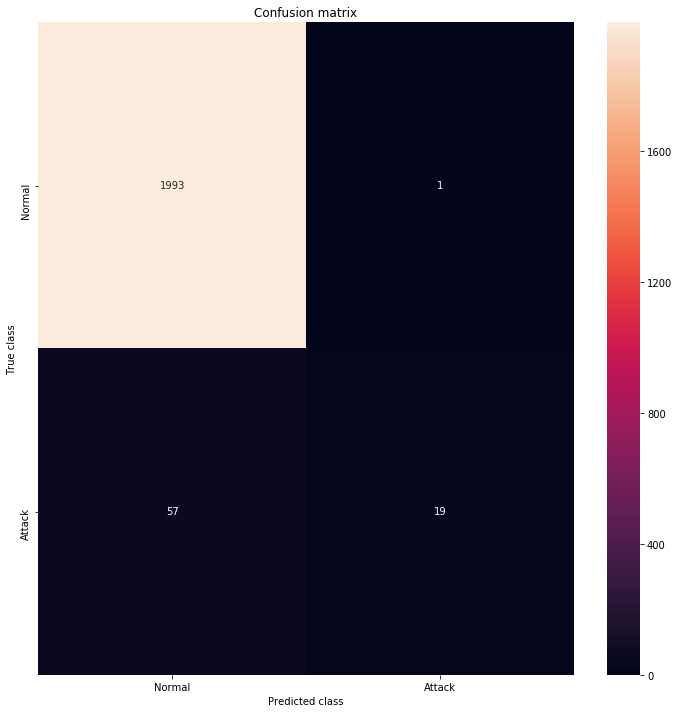

In [58]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Plot the ROC curve for the chosen threshold

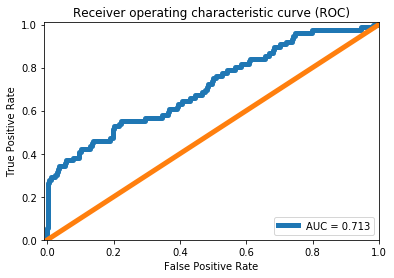

In [59]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()